# EUC 1993-2017: ECCOv4r4, GISS-G, and GISS-H

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
from pych.calc import haversine

In [2]:
ecco = xr.open_dataset('/workspace/results/eccov4r4/equatorial-under-current/euc_eccov4r4.nc')
gissg = xr.open_dataset('/workspace/results/giss-euc/giss_g.nc')
gissh = xr.open_dataset('/workspace/results/giss-euc/giss_h.nc')

### EUC: zonal transport where U>0, integrated 0->400m, 1.5S to 1.5N

Here averaged over 1993-2017

In [3]:
def convert_m3_to_sv(xda):
    if 'units' in xda.attrs:
        if xda.attrs['units'] == 'Sv':
            return xda
    xda *= 1e-6
    xda.attrs['units']='Sv'
    return xda.copy(deep=True)

In [4]:
gissg['ubar']=gissg['u'].sel(time=slice('1993','2017')).mean('time')
gissg['trsp_x'] = gissg['ubar']*gissg['drF']*gissg['dyG']

# all of the full cells
kbot = 15
gissg['euc'] = gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=slice(-1.25,1.25)).isel(Z=slice(0,kbot)).sum(['YC','Z'])

# get half the transport at latitudinal bounds, only full vertical depth points
gissg['euc'] += 0.5*gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=-1.5).isel(Z=slice(0,kbot)).sum('Z')
gissg['euc'] += 0.5*gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=1.5).isel(Z=slice(0,kbot)).sum('Z')

# get full latitudinal cells, fraction of bottom cell
dz = (400-gissg.Zp1[kbot])/gissg.drF[kbot]
gissg['euc'] += dz*gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=slice(-1.25,1.25)).isel(Z=kbot+1).sum(['YC'])

# get half latitudinal bounds, and fraction of bottom cell
gissg['euc'] += dz*0.5*gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=-1.5).isel(Z=kbot+1)
gissg['euc'] += dz*0.5*gissg['trsp_x'].where(gissg['ubar']>0,0.).sel(YC=1.5).isel(Z=kbot+1)

gissg['euc'] = convert_m3_to_sv(gissg['euc'])

/workspace/anaconda3/envs/py37_tim/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
gissh['ubar']=gissh['u'].sel(time=slice('1993','2017')).mean('time')
gissh['trsp_x'] = gissh['ubar']*gissh['drF']*gissh['dyF']

# all of the full cells
kbot = 12
gissh['euc'] = gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=slice(-1.25,1.25)).isel(Z=slice(0,kbot)).sum(['YC','Z'])

# get half the transport at latitudinal bounds, only full vertical depth points
gissh['euc'] += 0.5*gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=-1.5).isel(Z=slice(0,kbot)).sum('Z')
gissh['euc'] += 0.5*gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=1.5).isel(Z=slice(0,kbot)).sum('Z')

# get full latitudinal cells, fraction of bottom cell
# gissH goes exactly to 400m in first 12 cells, so this is actually not necessary
dz = (400-gissh.Zp1[kbot])/gissh.drF[kbot]
gissh['euc'] += dz*gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=slice(-1.25,1.25)).isel(Z=kbot+1).sum(['YC'])

# get half latitudinal bounds, and fraction of bottom cell
gissh['euc'] += dz*0.5*gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=-1.5).isel(Z=kbot+1)
gissh['euc'] += dz*0.5*gissh['trsp_x'].where(gissh['ubar']>0,0.).sel(YC=1.5).isel(Z=kbot+1)


gissh['euc'] = convert_m3_to_sv(gissh['euc'])

/workspace/anaconda3/envs/py37_tim/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### GISS-H zonal velocity problems

There are a few points where the velocity is O(10^30).
Obviously this causes problems.

Right now I'm simply ignore longitudes where these occur

In [6]:
gissh['euc'] = xr.where(gissh.euc>1e20,np.NAN,gissh.euc)

In [7]:
np.isnan(gissh.euc).sum()

<xarray.DataArray 'euc' ()>
array(18)

In [8]:
from matplotlib.ticker import MultipleLocator

In [38]:
def euc_plot(xda,xcoord='XG',ax=None,xskip=20,xminor_skip=10,yminor_skip=1):
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
    x=xda[xcoord]
    
    xbds = [140,-80]
    # Grab Pacific
    xda = xda.where((x<=xbds[0])|(x>=xbds[1]),drop=True)
    x_split=xda[xcoord]
    xda[xcoord]=xr.where(xda[xcoord]<=0,360+xda[xcoord],xda[xcoord])
    xda = xda.sortby(xcoord)
    
    xda.plot(ax=ax)
    
    xlabel_int = [xx for xx in np.concatenate([np.arange(xbds[0],181),np.arange(-179,xbds[1]+2)])]
    xlbl=[]
    for x in xlabel_int:
        if x>0:
            xlbl.append(r'%d$^\circ$E' % x)
        else:
            xlbl.append(r'%s$^\circ$W' % -x)
    x_slice = slice(None,None,xskip)
    ax.xaxis.set_ticks(xda[xcoord].values[x_slice])
    ax.xaxis.set_ticklabels(xlbl[x_slice])
    ax.xaxis.set_minor_locator(MultipleLocator(xminor_skip))
    ax.yaxis.set_minor_locator(MultipleLocator(yminor_skip))
    ax.set_xlim([xbds[0],xbds[1]+360])
    
    return ax

In [31]:
plt.rcParams.update({'figure.figsize':(18,6),'font.size':18,'text.usetex':True})

In [32]:
fig_dir='/workspace/results/eccov4r4/equatorial-under-current/figures/'

In [33]:
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

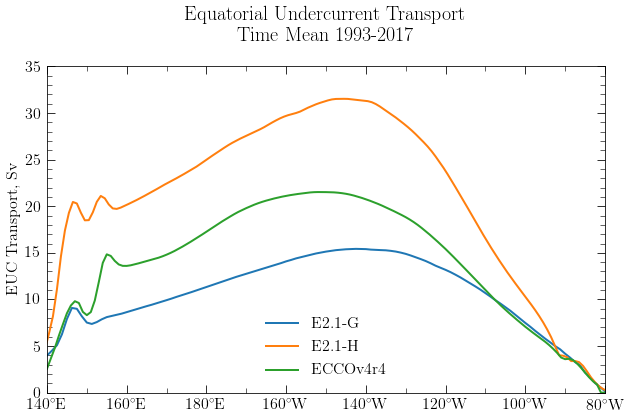

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax=euc_plot(gissg.euc,ax=ax)
ax=euc_plot(gissh.euc,xcoord='XC',ax=ax)
ax=euc_plot(ecco.trsp,xcoord='lon',ax=ax)
ax.set_xlabel('')
#ax.grid();
ax.tick_params(direction='in',which='major',length=8,
               top=True,right=True,pad=6)
ax.tick_params(direction='in',which='minor',length=5,
               top=True,right=True,pad=6)
ax.legend(('E2.1-G','E2.1-H','ECCOv4r4'),loc='lower center',frameon=False)

#          bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#           bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#           mode="expand", borderaxespad=0, ncol=3)
ax.set_title('Equatorial Undercurrent Transport\nTime Mean 1993-2017',fontsize=20,pad=25);
ax.set_ylabel('EUC Transport, Sv',fontsize=16)
ax.set_ylim([0,35])
fig.savefig(f'{fig_dir}/euc_comparison_1993-2017.png',dpi=300,
            bbox_inches='tight',pad_inches=1)